<a href="https://colab.research.google.com/github/junho328/Deep_learning_with_Pytorch/blob/main/Pytorch_CH7_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kospi.csv')
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']]= scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [ ]:
device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')

In [ ]:
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [ ]:
def seq_data(x,y,sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x)-sequence_length):
    x_seq.append(x[i:i+sequence_length])
    y_seq.append(y[i+sequence_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [ ]:
split = 200 
sequence_length = 5
x_seq, y_seq = seq_data(X,y,sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(),y_train_seq.size())
print(x_test_seq.size(),y_test_seq.size())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq,y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq,y_test_seq)
batch_size = 20
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size= batch_size, shuffle=False)

In [ ]:
input_size = x_seq.size(2)
num_layers=2
hidden_size=8

In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self,input_size,hidden_size,sequence_length,num_layers,device):
    super(VanillaRNN,self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length,1),nn.Sigmoid())

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out,_ = self.rnn(x,h0)
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out

In [ ]:
model = VanillaRNN(input_size=input_size, hidden_size=hidden_size,sequence_length = sequence_length, num_layers=num_layers,
                   device=device).to(device)

In [ ]:
criterion = nn.MSELoss()
num_epochs = 301
optimizer = optim.Adam(model.parameters(),lr=1e-3)

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:
    seq,target = data
    out = model(seq)
    loss = criterion(out,target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch%100==0:
    print('[epoch:%d]loss:%.4f'%(epoch,running_loss/n))

[epoch:0]loss:0.0065
[epoch:100]loss:0.0007
[epoch:200]loss:0.0005
[epoch:300]loss:0.0005


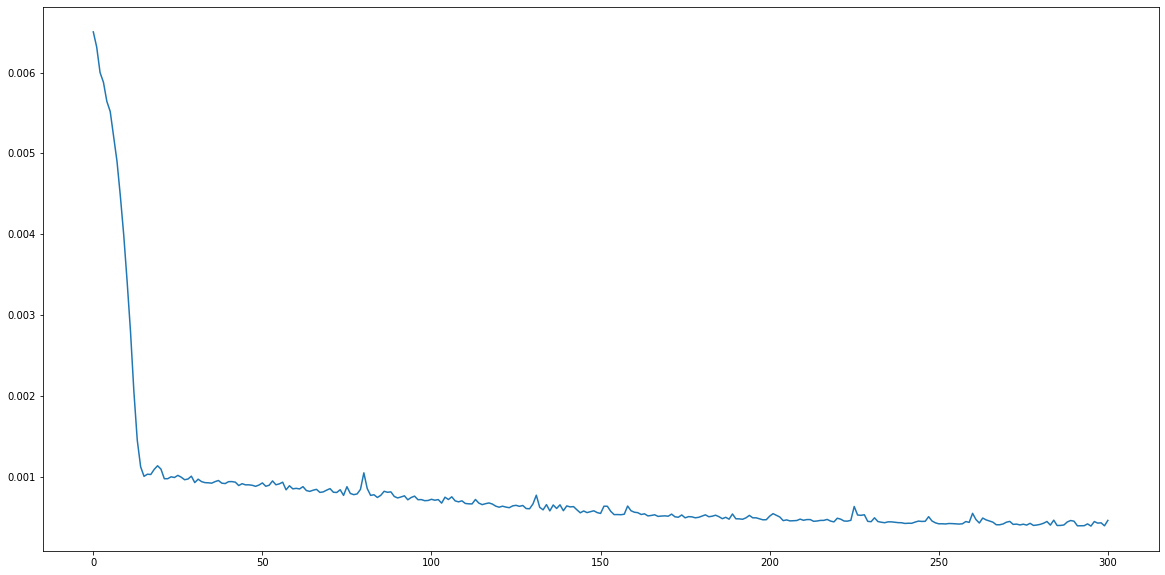

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

In [ ]:
concatdata = torch.utils.data.ConcatDataset([train,test])
data_loader= torch.utils.data.DataLoader(dataset=concatdata,batch_size=100)
with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq,target = data
    out = model(seq)
    pred += out.cpu().tolist()

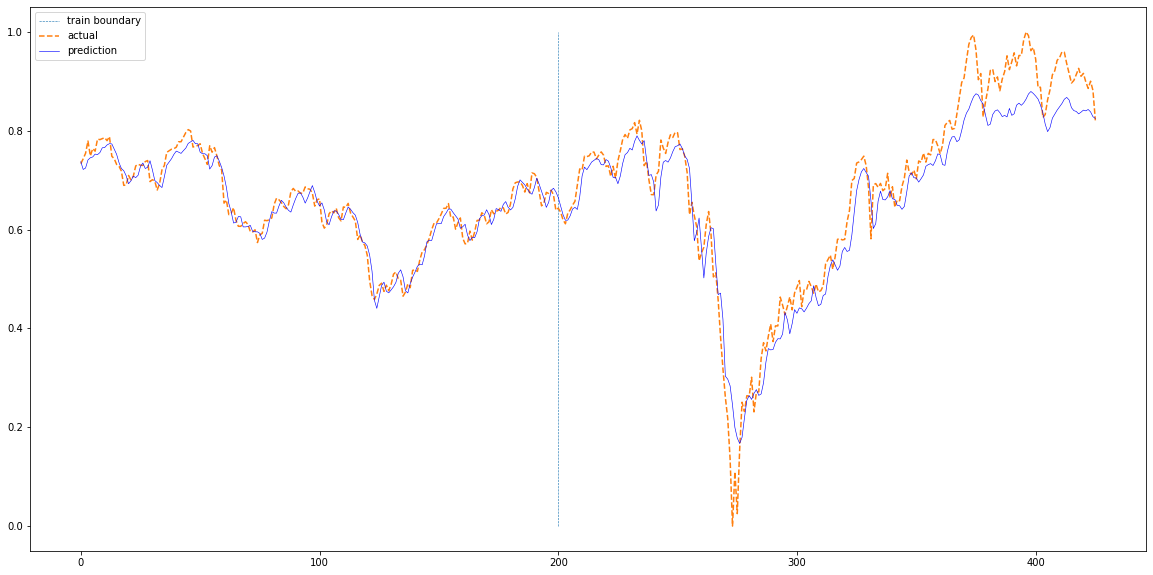

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--',linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b',linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

## RNN의 문제
- tanh 활성화 함수의 vanishing gradient
- 장기 의존성
- LSTM으로 보완

In [ ]:
class LSTM(nn.Module):
  def __init__(self,input_size,hidden_size,sequence_length,num_layers,device):
    super(LSTM,self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size*sequence_length,1)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size()[0],self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0],self.hidden_size).to(self.device)
    out,_ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out

In [ ]:
class GRU(nn.Module): # Gated Recurrent Units
  def __init__(self,input_size,hidden_size,sequence_length,num_layers, device):
    super(GRU,self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(input_size,hidden_size,num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size*sequence_length,1)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size).to(self.device)
    out,_ = self.gru(x,h0)
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [ ]:
tensor_mode = torchvision.transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data',train=True,transform=tensor_mode,download=True)
testset = torchvision.datasets.MNIST(root='./data',train=False,transform=tensor_mode,download=True)
trainloader = DataLoader(trainset, batch_size = 128, shuffle=True)
testloader = DataLoader(testset,batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class BiLSTM(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,seq_length,num_classes,device):
    super(BiLSTM,self).__init__()
    self.device=device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
    self.fc= nn.Linear(seq_length*hidden_size*2,num_classes)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers*2, x.size(0),self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers*2, x.size(0),self.hidden_size).to(self.device)
    out,_ = self.lstm(x,(h0,c0))
    out = out.reshape(-1,self.seq_length*self.hidden_size*2)
    out = self.fc(out)
    return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sequence_length = trainset.data.size(1)
input_size = trainset.data.size(2)
num_layers = 2
hidden_size = 12
num_classes = 10

In [ ]:
model = BiLSTM(input_size, hidden_size, num_layers, sequence_length, num_classes, device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=5e-3)

In [ ]:
for epoch in range(20):
  correct = 0
  total = 0
  for data in trainloader:
    optimizer.zero_grad()
    inputs,labels = data[0].to(device).squeeze(1),data[1].to(device)
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    _,predicted = torch.max(outputs.detach(),1)
    total += labels.size(0)
    correct += (predicted==labels).sum().item()

  print('[%d] train acc: %.2f'%(epoch,100*correct/total))

[0] train acc: 91.67
[1] train acc: 97.56
[2] train acc: 98.17
[3] train acc: 98.48
[4] train acc: 98.67
[5] train acc: 98.89
[6] train acc: 99.00
[7] train acc: 99.11
[8] train acc: 99.17
[9] train acc: 99.25
[10] train acc: 99.32
[11] train acc: 99.37
[12] train acc: 99.47
[13] train acc: 99.37
[14] train acc: 99.48
[15] train acc: 99.49
[16] train acc: 99.55
[17] train acc: 99.58
[18] train acc: 99.57
[19] train acc: 99.64


In [ ]:
def accuracy(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for data in dataloader:
      inputs,labels = data[0].to(device).squeeze(1),data[1].to(device)
      outputs, model(inputs)
      _,predicted = torch.max(outputs,1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()

  acc = 100*correct/total
  model.train()
  return acc

In [ ]:
train_acc = accuracy(trainloader)
test_acc = accuracy(testloader)
print('Train:',train_acc,'Test:',test_acc)

RuntimeError: ignored